In [1]:
# Add the path to the slack-pack/code/ folder in order to be able to import nlp module
import sys, os

NLP_PATH = '/'.join(os.path.abspath('.').split('/')[:-1]) + '/'
sys.path.append(NLP_PATH)

## Exploration on Distances between Geometric Representations

The following contains explorations of different distances between representation objects, as well as an attempt at a new classification algorithm that performs hierarchical clustering on the distance matrix of all messages (this attempt was discontinued due to losing the sequential nature of the messages)

In [2]:
%matplotlib inline
from nlp.text import extractor as xt

from nlp.geometry import repr as gr
from nlp.geometry import dist as gd
from nlp.grammar import tokenizer as gt
from nlp.text import window as gw

from nlp.models import similarity_calculation as gsc
from nlp.models import message_classification as gmc

### Different representations

In [2]:
gr.list_corpora()

['glove.6B.100d.txt', 'glove.6B.300d.txt']

In [3]:
%%time
# Initialize the GloVe representation
glove100_rep = gr.GloVe('glove.6B.100d.txt')

CPU times: user 12.6 s, sys: 514 ms, total: 13.1 s
Wall time: 13.5 s


In [4]:
%%time
# Initialize the GloVe representation
glove300_rep = gr.GloVe('glove.6B.300d.txt')

CPU times: user 32.3 s, sys: 1.35 s, total: 33.6 s
Wall time: 34.2 s


### Generate Data

Such as the __Message Stream__, a __corpus of all words in GloVe__ , a __corpus of the message stream__ and a list with all the __messages in the stream__:

In [5]:
# Initialize the extractor (JSON or Cassandra)
casdb = xt.CassandraExtractor(cluster_ips=['54.175.189.47'],
                              session_keyspace='test_keyspace',
                              table_name='boondoggle_messages')

In [6]:
# Generate message stream
message_stream = casdb.get_messages(type_of_query='hour', channel='general', min_words=5)

all_messages = [ msg.text.lower() for msg in message_stream ]

all_words = set()
for msg in all_messages:
    all_words.update( msg.split() )

In [7]:
print 'Messages:', len(all_messages), ' --  Words:', len(all_words)

Messages: 120  --  Words: 1155


### Manually-generated comparisons

In [7]:
gd.cosine(glove100_rep('Totally! Do you have a place to stay?'), 
          glove100_rep('Yes! Have you got a location to sleep?') )

0.97330725717986166

In [8]:
gd.cosine(glove300_rep('Totally! Do you have a place to stay?'), 
          glove300_rep('Yes! Have you got a location to sleep?') )

0.93553232640583517

In [9]:
gd.cosine(glove100_rep('Totally! Do you have a place to stay?'), 
          glove100_rep('Last chance to buy this stuff') )

0.94934566376127993

In [10]:
gd.cosine(glove300_rep('Totally! Do you have a place to stay? horses are red and violets have too many rocks'), 
          glove300_rep('Last chance to buy this stuff truck is my kind of transportation because I like pokemon') )

0.83978492330111754

In [11]:
gd.cosine(glove100_rep('Horse'), 
          glove100_rep('Glass') )

0.1613468850241957

### Message-to-message Distances

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns

#### Random numbers

In [10]:
num_dim = 300
num_words = [10, 12]
r1 = np.random.uniform(low=0, high=10, size=[num_words[0], num_dim]).mean(axis=0)
r2 = np.random.uniform(low=0, high=10, size=[num_words[1], num_dim]).mean(axis=0)

print('COSINE:', gd.cosine( r1, r2 ))
print('JS:', gd.jensen_shannon( r1, r2 ))
print('CROSS-ENTROPY:', gd.cross_entropy( r1, r2 ))

('COSINE:', 0.96727804074048396)
('JS:', 0.0087001933448315402)
('CROSS-ENTROPY:', 0.034859118737011155)


In [31]:
def dist_randnum(distance, reps, num_words):
    
    return map(lambda x: distance(np.random.uniform(low=0, high=10, size=[num_words[0], num_dim]).mean(axis=0),
                                  np.random.uniform(low=0, high=10, size=[num_words[1], num_dim]).mean(axis=0)),
               xrange(reps))

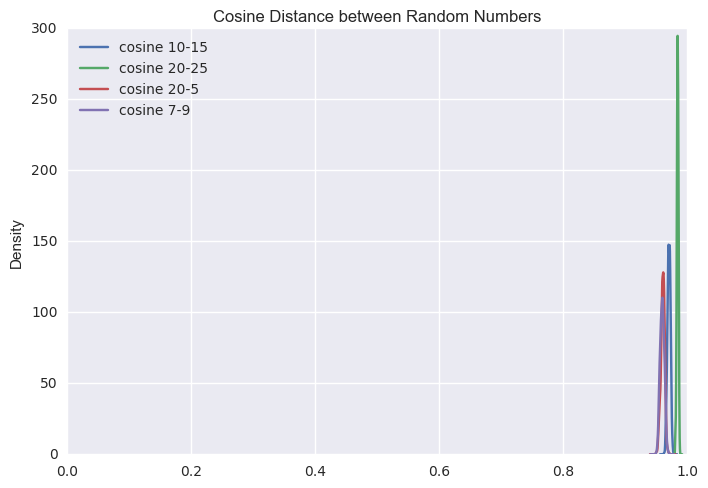

In [105]:
pd.DataFrame({'cosine 7-9': dist_randnum(gd.cosine, 500, [7, 9]),
              'cosine 10-15': dist_randnum(gd.cosine, 500, [10, 12]),
              'cosine 20-5': dist_randnum(gd.cosine, 500, [20, 5]),
              'cosine 20-25': dist_randnum(gd.cosine, 500, [20, 22]),
             }).plot(kind='kde', title='Cosine Distance between Random Numbers', xlim=[0,1]);

#### Random words out of GloVe

In [29]:
num_words = [12, 10]

## Random words

VOCAB = len(glove100_rep.vocab.keys())

sen1 = np.random.choice(glove100_rep.vocab.keys(), size=num_words[0])
sen2 = np.random.choice(glove100_rep.vocab.keys(), size=num_words[1])

print ''
print 'Sentence 1:', ' '.join( sen1 )
print ''
print 'Sentence 2:', ' '.join( sen2 )

repr1 = np.array( map(lambda x: glove300_rep[x], sen1) )
repr2 = np.array( map(lambda x: glove300_rep[x], sen2) )

print ''
print ' -- Random words --'
print 'COSINE mean:', gd.cosine( np.mean(repr1, axis=0) , np.mean(repr2, axis=0) )
print 'COSINE median:', gd.cosine( np.median(repr1, axis=0) , np.median(repr2, axis=0) )


Sentence 1: abcdefghijklmnopqrstuvwxyz kopit cefn recommit rishabham morandi choiseul hoesch 555,000 cravath 3-plus mountaga

Sentence 2: gadgetry basilea skulsk 100:1 tanizaki lasithi vinko steffie bhupathy 75-degree

 -- Random words --
COSINE mean: 0.620739899243
COSINE median: 0.565578515676


In [64]:
def cos_randword(vocab, reps, num_words):
    
    get_repr = lambda num: np.array( map(lambda x: glove300_rep[x], np.random.choice(vocab, size=num)) )
    
    return map(lambda x: gd.cosine(get_repr(num_words[0]).mean(axis=0),
                                   get_repr(num_words[1]).mean(axis=0)),
               xrange(reps))

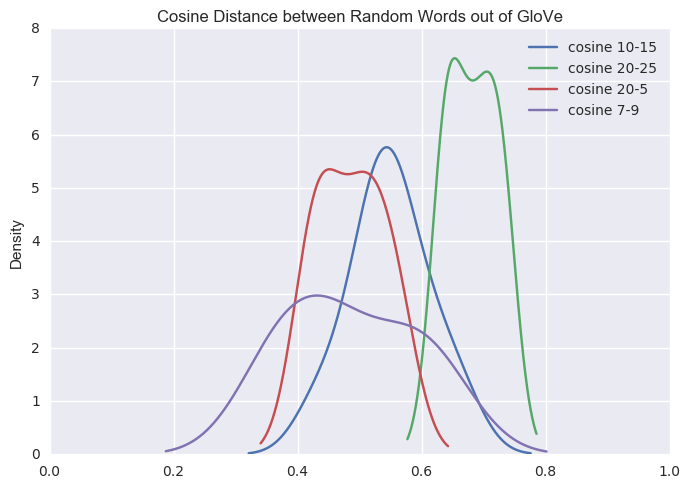

In [104]:
pd.DataFrame({'cosine 7-9': cos_randword(glove100_rep.vocab.keys(), 10, [7, 9]),
              'cosine 10-15': cos_randword(glove100_rep.vocab.keys(), 10, [10, 12]),
              'cosine 20-5': cos_randword(glove100_rep.vocab.keys(), 10, [20, 5]),
              'cosine 20-25': cos_randword(glove100_rep.vocab.keys(), 10, [20, 22]),
             }).plot(kind='kde', title='Cosine Distance between Random Words out of GloVe', xlim=[0,1]);

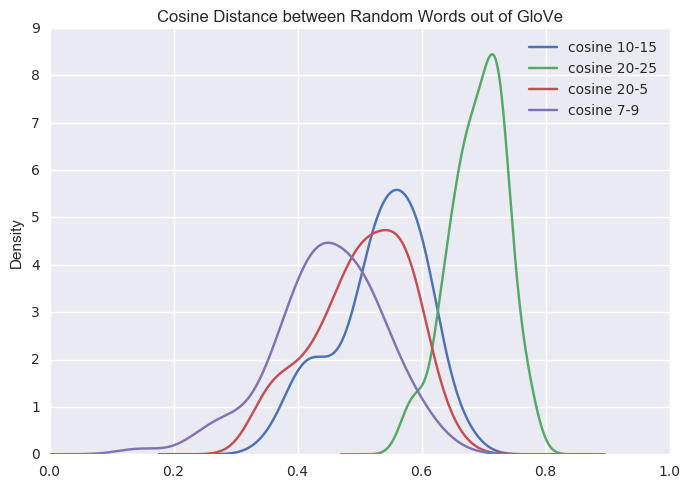

In [103]:
pd.DataFrame({'cosine 7-9': cos_randword(glove100_rep.vocab.keys(), 100, [7, 9]),
              'cosine 10-15': cos_randword(glove100_rep.vocab.keys(), 100, [10, 12]),
              'cosine 20-5': cos_randword(glove100_rep.vocab.keys(), 100, [20, 5]),
              'cosine 20-25': cos_randword(glove100_rep.vocab.keys(), 100, [20, 22]),
             }).plot(kind='kde', title='Cosine Distance between Random Words out of GloVe', xlim=[0,1]);

#### Random words out of the Message Stream

In [73]:
num_words = [12, 10]

## Random words out of our corpus

sen3 = np.random.choice(list(all_words), size=num_words[0])
sen4 = np.random.choice(list(all_words), size=num_words[1])

repr3 = np.array( map(lambda x: glove300_rep[x], sen3) )
repr4 = np.array( map(lambda x: glove300_rep[x], sen4) )

repr3_r = glove300_rep(' '.join(sen3))
repr4_r = glove300_rep(' '.join(sen4))

print ''
print 'Sentence 3:', ' '.join( sen1 )
print ''
print 'Sentence 4:', ' '.join( sen2 )

print ''
print '-- Corpus of words (random) --'
print 'COSINE mean:', gd.cosine( np.mean(repr3, axis=0) , np.mean(repr4, axis=0) )
print 'COSINE median:', gd.cosine( np.median(repr3, axis=0) , np.median(repr4, axis=0) )
print 'COSINE own:', gd.cosine( repr3_r , repr4_r )


Sentence 3: abcdefghijklmnopqrstuvwxyz kopit cefn recommit rishabham morandi choiseul hoesch 555,000 cravath 3-plus mountaga

Sentence 4: gadgetry basilea skulsk 100:1 tanizaki lasithi vinko steffie bhupathy 75-degree

-- Corpus of words (random) --
COSINE mean: 0.380356148019
COSINE median: 0.312004828094
COSINE own: 0.380356148019


#### Random message out of the Message Stream

In [91]:
reload(gt)

<module 'nlp.grammar.tokenizer' from 'nlp/grammar/tokenizer.py'>

In [92]:
clean_message = gt.SimpleCleaner()

In [94]:
## Full messages

sen5 = np.random.choice(all_messages).lower().split()
sen6 = np.random.choice(all_messages).lower().split()

print ''
print 'Sentence 5:', ' '.join( sen5 )
print ''
print 'Sentence 6:', ' '.join( sen6 )

repr5 = np.array( map(lambda x: glove300_rep[x], sen5) )
repr6 = np.array( map(lambda x: glove300_rep[x], sen6) )

repr5_r = glove300_rep(' '.join(sen5))
repr6_r = glove300_rep(' '.join(sen6))

print ''
print '-- Full Messages --'
print 'COSINE mean:', gd.cosine( np.mean(repr5, axis=0) , np.mean(repr6, axis=0) )
print 'COSINE median:', gd.cosine( np.median(repr5, axis=0) , np.median(repr6, axis=0) )
print 'COSINE own repr:', gd.cosine( repr5_r , repr6_r )


## Process the messages

sen5_proc = clean_message(' '.join(sen5)).split()
sen6_proc = clean_message(' '.join(sen6)).split()

print ''
print 'Sentence 5 ({:>2}-->{:>2}):'.format(len(sen5), len(sen5_proc)), ' '.join(sen5_proc)
print ''
print 'Sentence 6 ({:>2}-->{:>2}):'.format(len(sen6), len(sen6_proc)), ' '.join(sen6_proc)

pr_repr5 = np.array( map(lambda x: glove300_rep[x], sen5_proc) )
pr_repr6 = np.array( map(lambda x: glove300_rep[x], sen6_proc) )

pr_repr5_r = glove300_rep(' '.join(sen5_proc))
pr_repr6_r = glove300_rep(' '.join(sen6_proc))

print ''
print '-- Full (processed) Messages --'
print 'COSINE mean:', gd.cosine( np.mean(pr_repr5, axis=0) , np.mean(pr_repr6, axis=0) )
print 'COSINE median:', gd.cosine( np.median(pr_repr5, axis=0) , np.median(pr_repr6, axis=0) )
print 'COSINE own repr:', gd.cosine( pr_repr5_r , pr_repr6_r )


Sentence 5: im jealous. <@u16raecf5> and i have nothing but *hard* sandbagging by our mission contacts...

Sentence 6: im sorry. its the sudafed

-- Full Messages --
COSINE mean: 0.43913263217
COSINE median: 0.161813289559
COSINE own repr: 0.43913263217

Sentence 5 (14--> 6): im jealous hard sandbagging mission contacts

Sentence 6 ( 5--> 3): im sorry sudafed

-- Full (processed) Messages --
COSINE mean: 0.336893253621
COSINE median: 0.350691403438
COSINE own repr: 0.336893253621


In [95]:
def cos_randmessage(messages, reps, num_words, clean=False):
    
    if clean:
        get_repr = lambda num: np.array( map(lambda x: glove300_rep[x], np.random.choice(messages).lower().split() ) )
    else:
        get_repr = lambda num: np.array( map(lambda x: glove300_rep[x],
                                             clean_message(np.random.choice(messages)).lower().split() ) )
    
    return map(lambda x: gd.cosine(get_repr(num_words[0]).mean(axis=0),
                                   get_repr(num_words[1]).mean(axis=0)),
               xrange(reps))

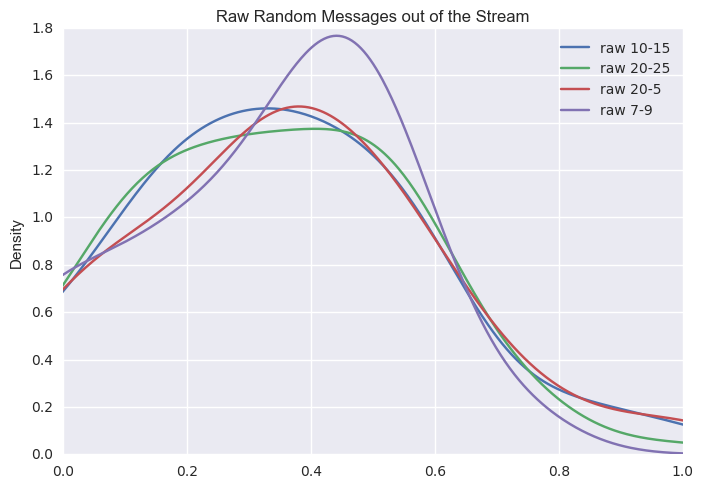

In [106]:
pd.DataFrame({'raw 7-9': cos_randmessage(all_messages, 100, [7, 9]),
              'raw 10-15': cos_randmessage(all_messages, 100, [10, 12]),
              'raw 20-5': cos_randmessage(all_messages, 100, [20, 5]),
              'raw 20-25': cos_randmessage(all_messages, 100, [20, 22]),
             }).plot(kind='kde', title='Raw Random Messages out of the Stream', xlim=[0,1]);

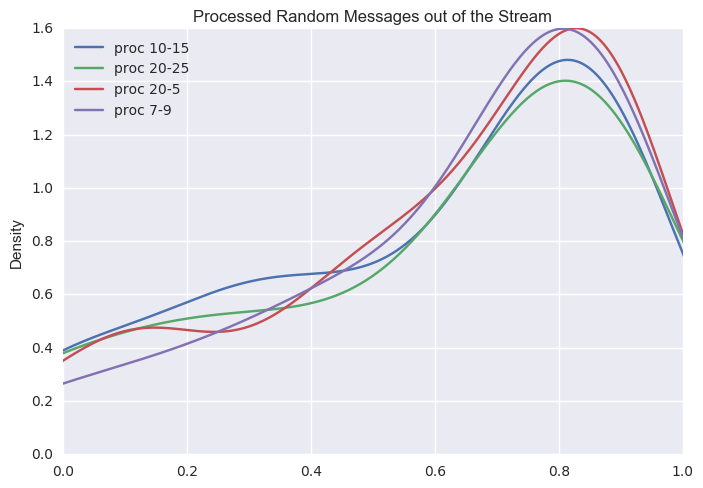

In [107]:
pd.DataFrame({'proc 7-9': cos_randmessage(all_messages, 100, [7, 9], clean=True),
              'proc 10-15': cos_randmessage(all_messages, 100, [10, 12], clean=True),
              'proc 20-5': cos_randmessage(all_messages, 100, [20, 5], clean=True),
              'proc 20-25': cos_randmessage(all_messages, 100, [20, 22], clean=True),
             }).plot(kind='kde', title='Processed Random Messages out of the Stream', xlim=[0,1]);

In [126]:
def cos_randmessage_ownrepr(representation, messages, reps, num_words, clean=False):
    
    if clean:
        get_repr = lambda num: representation( np.random.choice(messages).lower() )
    else:
        get_repr = lambda num: representation( clean_message(np.random.choice(messages)) )
    
    return map(lambda x: gd.cosine(get_repr(num_words[0]).mean(axis=0),
                                   get_repr(num_words[1]).mean(axis=0)),
               xrange(reps))

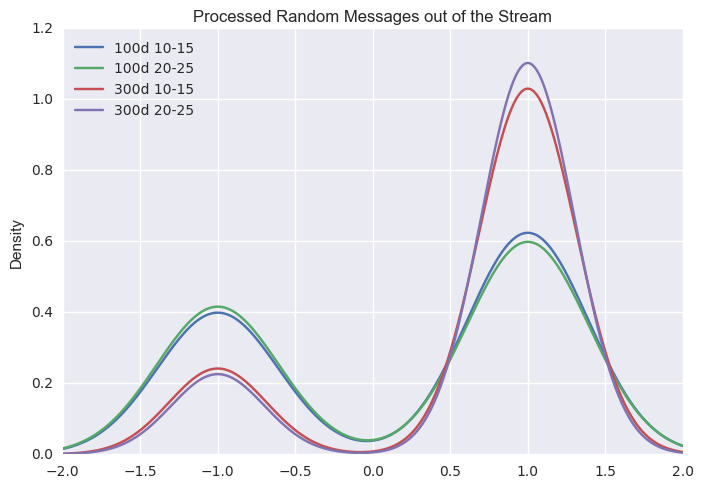

In [131]:
pd.DataFrame({'100d 10-15': cos_randmessage_ownrepr(glove100_rep, all_messages, 100, [10, 12], clean=True),
              '100d 20-25': cos_randmessage_ownrepr(glove100_rep, all_messages, 100, [20, 22], clean=True),
              '300d 10-15': cos_randmessage_ownrepr(glove300_rep, all_messages, 100, [10, 12], clean=True),
              '300d 20-25': cos_randmessage_ownrepr(glove300_rep, all_messages, 100, [20, 22], clean=True),
             }).plot(kind='kde', title='Processed Random Messages out of the Stream');

### Message vs Message distance in the Message stream

In [140]:
from itertools import product
import matplotlib.pyplot as plt

from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix

In [11]:
clean = gt.SimpleCleaner()

def dist_m2m(m1, m2):
    # tokenize
    text1 = clean(m1.lower())
    text2 = clean(m2.lower())

    # get geometric representation
    rep1 = glove100_rep(text1)
    rep2 = glove100_rep(text2)
    
    return gd.cosine(rep1, rep2)

In [162]:
# Get all distance matrix
NUM_MESSAGES = len(all_messages)

dist_mat = np.zeros([NUM_MESSAGES, NUM_MESSAGES])

for m1, m2 in product(xrange(NUM_MESSAGES), xrange(NUM_MESSAGES)):
    dist_mat[m1,m2] = dist_m2m(all_messages[m1], all_messages[m2])

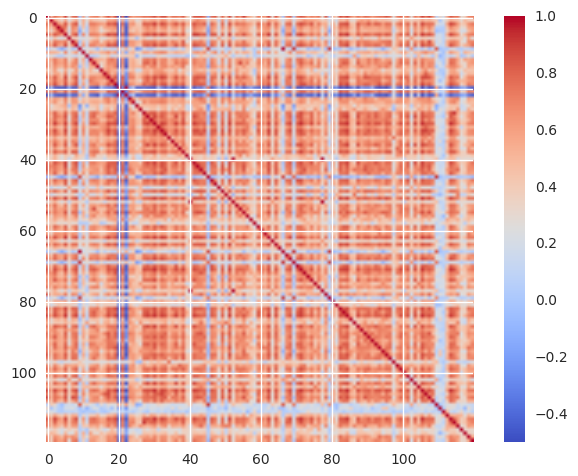

In [163]:
plt.imshow(dist_mat, cmap='coolwarm')
plt.colorbar()

Now, what we want is to be able to block these messages together so as to generate 

In [164]:
def block_matrix(matrix, threshold):
    # Reorder matrix
    mat_csr = csr_matrix(matrix < threshold)

    # Let's try to group these messages with hierarchical clustering
    ordering = reverse_cuthill_mckee(mat_csr)
    
    return matrix[ordering, :][:, ordering]

def best_cut(series):
    N = len(series)
    diff_val = map( lambda x: np.median(series[:x]) / np.median(series[x:]) , xrange(N//20, N*3/4) )
    return np.argmax(diff_val)

In [295]:
def plot_thresh(matrix, threshold):

    # reorder the matrix
    reordered_mat = block_matrix(matrix, threshold)
    best_split = best_cut(reordered_mat[0, :])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow( reordered_mat, cmap='coolwarm')
    ax[1].plot(reordered_mat[0, :])
    ax[1].axvline(x=best_split, c='green')
    
    return reordered_mat, best_split

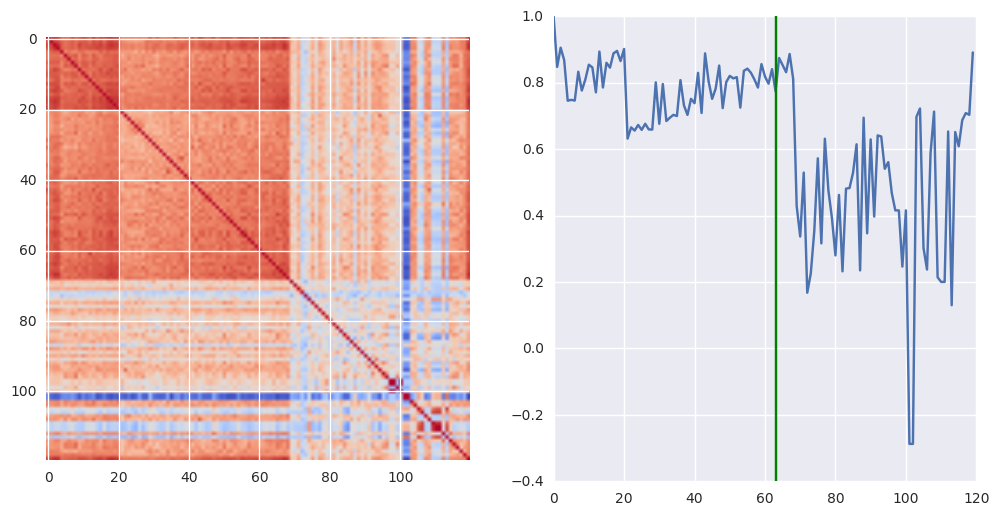

In [296]:
reord_mat, cut = plot_thresh(dist_mat, .7)

__Recursive algorithm for generating the Matrix Blocks__

In [326]:
def rec_block(matrix, threshold=1.):

    # reorder the matrix
    reordered_mat = block_matrix(matrix, threshold)

    # recurse if not sufficiently small
    if (matrix.shape[0] < 15) or (threshold < .2):
        return reordered_mat
    
    else:
        # find split
        split = best_cut(reordered_mat[0, :])
        
        # recurse the smaller matrix
        reordered_mat[split:, split:] = rec_block(reordered_mat[split:, split:], threshold-.15)

        return reordered_mat


def dual_rec_block(matrix, threshold=1.):

    # reorder the matrix
    try:
        reordered_mat = block_matrix(matrix, threshold)
    except ValueError:
        reordered_mat = matrix
    
    # recurse if not sufficiently small
    if (matrix.shape[0] < 15) or (threshold < .2) or (threshold > 1.2):
        return reordered_mat
    
    else:
        # find split
        split = best_cut(reordered_mat[0, :])
        
        # recurse the smaller matrix
        reordered_mat[:split, :split] = dual_rec_block(reordered_mat[:split, :split], threshold+.15)
        reordered_mat[split:, split:] = dual_rec_block(reordered_mat[split:, split:], threshold-.15)

        return reordered_mat

In [328]:
%%timeit
rec_block(dist_mat, .75)

10 loops, best of 3: 15.8 ms per loop


In [329]:
%%timeit
dual_rec_block(dist_mat, .85)

10 loops, best of 3: 54.9 ms per loop


There is difference, but let's try it out in conjunction with the generation of the distance matrix first.

__Putting it all together__

In [359]:
from scipy.spatial.distance import cdist

In [369]:
def get_repr(msg):
    return np.array( glove100_rep( clean_message(msg) ) )

In [378]:
%%timeit
np_msgs = np.array( map(get_repr, all_messages*100) )
fdm = cdist(np_msgs, np_msgs, metric='cosine')

1 loop, best of 3: 2.8 s per loop


And finally, we can create the full `cluster_messages` function:

In [386]:
def cluster_messages(message_list):
    # Get all distance matrix
    np_msgs = np.array( map(get_repr, message_list) )
    fdm = cdist(np_msgs, np_msgs, metric='cosine')    

    # apply the recursive algorithm
    return dual_rec_block(fdm, .85)

In [ ]:
%%timeit
a = cluster_messages(all_messages)

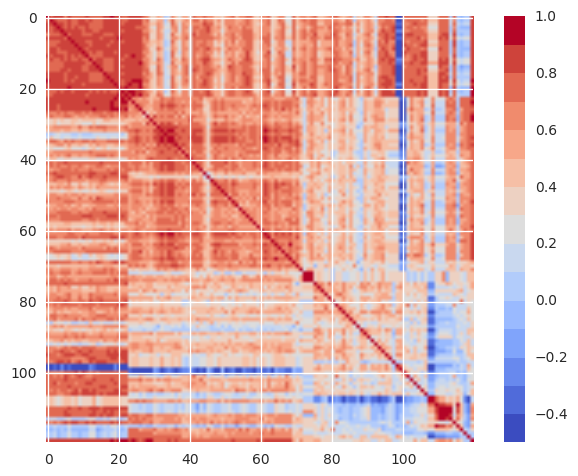

In [358]:
disc_coolwarm = plt.get_cmap('coolwarm', 15)
plt.imshow( dual_rec_block(dist_mat, .85), cmap=disc_coolwarm)
plt.colorbar()